In [1]:
import os
import PIL
from PIL import Image, ImageTk, ImageFilter
import tkinter as tk
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

# os.chdir('/home/stefan/image-processing')
os.chdir('/home/milan/Desktop/image-processing')

# Need GUI for selecting pictures
img = Image.open('warrior.jpeg')blur_matrixx = zoom(img, 3)blur_matrixx = zoom(img, 3)   

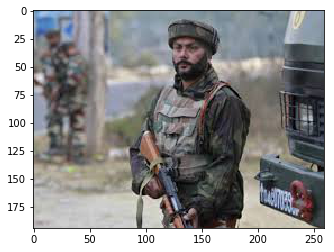

In [2]:
plt.imshow(img)
plt.show()

In [3]:
def bilinear_interpolation(x, y, points):
    '''Interpolate (x,y) from values associated with four points.

    The four points are a list of four triplets:  (x, y, value).
    The four points can be in any order.  They should form a rectangle.

        >>> bilinear_interpolation(12, 5.5,
        ...                        [(10, 4, 100),
        ...                         (20, 4, 200),
        ...                         (10, 6, 150),
        ...                         (20, 6, 300)])
        165.0

    '''
    
    points = sorted(points) # order points by x, then by y
    if len(points) == 4:
        (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

#         if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
#             raise ValueError('points do not form a rectangle')
#         if not x1 <= x <= x2 or not y1 <= y <= y2:
#             raise ValueError('(x, y) not within the rectangle')
        return (q11 * (x2 - x) * (y2 - y) +
                q21 * (x - x1) * (y2 - y) +
                q12 * (x2 - x) * (y - y1) +
                q22 * (x - x1) * (y - y1)
               ) / ((x2 - x1) * (y2 - y1))
    
    if len(points) == 2:
        (x1, y1, q11), (_x1, y2, q12) = points
        if x1 == _x1:
            return (q11  * (y2 - y) + q12 * (y - y1)) / (y2 - y1)       
        else:
            return (q11 * (_x1 - x) + q12 * (x - x1)) / (_x1 - x1)

In [4]:
def rescaling(image, scale):
    # convert image to matrix
    matrix = np.asarray(image)
    old_x = matrix.shape[0]
    old_y = matrix.shape[1]
    # create new dimension
    new_x = int(scale * matrix.shape[0])
    new_y = int(scale * matrix.shape[1])
    new_z = matrix.shape[2]
    new_matrix = np.zeros((new_x, new_y, new_z))
    for z in range(new_z):
        for i in range(new_x):
            for j in range(new_y):
                if scale < 1:
                    # key step, since scale < 1, 1/scale > 1, and this will be our step for which pixels to interpolate
                    x = float(i)*(1/scale)
                    y = float(j)*(1/scale)
                    if x.is_integer():
                        x = int(x)
                        if y.is_integer():
                            # if x and y are integers than we take that position from original image
                            y = int(y)
                            new_matrix[i, j, z] = matrix[x, y, z]
                        else:
                            # x is integer, y is not so we need only to interpolate y coordinate
                            y1 = int(y)
                            y2 = y1 + 1
                            new_matrix[i, j, z] = bilinear_interpolation(x, 
                                                                     y, 
                                                                     [(x, y1, matrix[x, y1, z]), 
                                                                      (x, y2, matrix[x, y2, z])])
                    else:
                        if y.is_integer():
                            y = int(y)
                            x1 = int(x)
                            x2 = x1 + 1
                            new_matrix[i, j, z] = bilinear_interpolation(x, 
                                                                     y, 
                                                                     [(x1, y, matrix[x1, y, z]), 
                                                                      (x2, y, matrix[x2, y, z])])
                        else:
                            # if neither x nor y are integers, we take rectangle around them, and use bilinear interpolation
                            x1 = int(x)
                            x2 = x1 + 1
                            y1 = int(y)
                            y2 = y1 + 1
                            new_matrix[i, j, z] = bilinear_interpolation(x, 
                                                                     y, 
                                                                     [(x1, y1, matrix[x1, y1, z]),
                                                                      (x1, y2, matrix[x1, y2, z]),
                                                                      (x2, y1, matrix[x1, y2, z]),
                                                                      (x2, y2, matrix[x2, y2, z])])
                elif scale > 1:
                    new_matrix = matrix[central_x - int(old_x*new_scale/2) : central_x + int(old_x*new_scale/2),
                                        central_y - int(old_y*new_scale/2) : central_y + int(old_y*new_scale/2),
                                        z]
                    
                else:
                    return plt.imshow(Image.fromarray(np.uint8(matrix)))
    
    return new_matrix

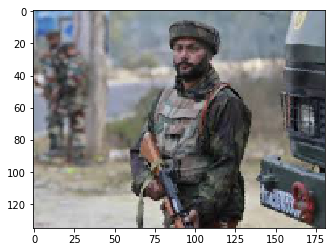

In [20]:
new_mat = zoom.rescaling(img, 0.7)
plt.imshow(Image.fromarray(np.uint8(new_mat)))

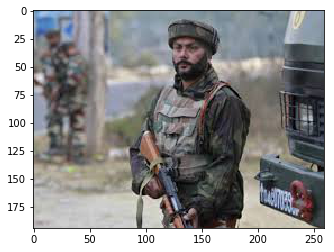

In [6]:
plt.imshow(img)

In [7]:
def calc_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

In [8]:
def closest_pixels(pixel, points):
    distances = []
    for point in points:
        distances.append(calc_distance(pixel, point))
    distances = np.array(distances)
    return points[distances.argsort()[:1]][0]

In [43]:
def find_indices(pixel, matrix, scale):
    return (max(0, pixel[0] - int(scale**4)), min(matrix.shape[0], pixel[0] + int(scale**4))),\
           (max(0, pixel[1] - int(scale**4)), min(matrix.shape[1], pixel[1] + int(scale**4)))

In [44]:
def find_non_negative(indices, matrix):
    x_min, x_max = indices[0]
    y_min, y_max = indices[1]
    result = []
    for x in range(x_min, x_max):
        for y in range(y_min, y_max):
            if matrix[x, y] > 0:
                  result.append((x, y))
    return np.array(result)

In [45]:
def zoom(image, scale):
    if scale > 1.5:
        image = image.filter(ImageFilter.BLUR())
    new_scale = 1/scale
    # convert image to matrix
    matrix = np.asarray(image)
    old_x = matrix.shape[0]
    old_y = matrix.shape[1]
    central_x, central_y = int(old_x/2), int(old_y/2)
    # create new dimension
    new_x = matrix.shape[0]
    new_y = matrix.shape[1]
    new_z = matrix.shape[2]
    new_matrix = np.zeros((new_x, new_y, new_z)) - 1
    temp_matrix = matrix[central_x - int(old_x*new_scale/2) : central_x + int(old_x*new_scale/2),
                                        central_y - int(old_y*new_scale/2) : central_y + int(old_y*new_scale/2),
                                        :]
    x_factor = old_x/temp_matrix.shape[0]
    y_factor = old_y/temp_matrix.shape[1]
    for z in range(new_z):
        for i in range(temp_matrix.shape[0]-1):
            for j in range(temp_matrix.shape[1]-1):
                x = float(i) * x_factor
                y = float(j) * y_factor
                new_matrix[int(x), int(y), z] = temp_matrix[i, j, z]
    for z in range(new_z):
        print('Z is:', z)
        for i in range(new_x):
            if i % 10 == 0:
                print('I is:', i)
            for j in range(new_y):
                if new_matrix[i, j, z] < 0:
                    index = find_indices((i, j), new_matrix, scale)
    #                 print(index)
                    coordinates = find_non_negative(index, new_matrix[:, :, z])
                    t1 = closest_pixels((i, j), coordinates)
                    new_matrix[i, j, z] = new_matrix[t1[0], t1[1], z]
    return new_matrix

In [48]:
blur_matrixx = zoom(img.filter(ImageFilter.BLUR()), 3)

Z is: 0
I is: 0
I is: 10
I is: 20
I is: 30
I is: 40
I is: 50
I is: 60
I is: 70
I is: 80
I is: 90
I is: 100
I is: 110
I is: 120
I is: 130
I is: 140
I is: 150
I is: 160
I is: 170
I is: 180
I is: 190
Z is: 1
I is: 0
I is: 10
I is: 20
I is: 30
I is: 40
I is: 50
I is: 60
I is: 70
I is: 80
I is: 90
I is: 100
I is: 110
I is: 120
I is: 130
I is: 140
I is: 150
I is: 160
I is: 170
I is: 180
I is: 190
Z is: 2
I is: 0
I is: 10
I is: 20
I is: 30
I is: 40
I is: 50
I is: 60
I is: 70
I is: 80
I is: 90
I is: 100
I is: 110
I is: 120
I is: 130
I is: 140
I is: 150
I is: 160
I is: 170
I is: 180
I is: 190


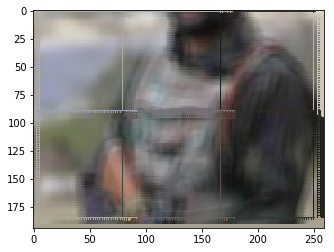

In [42]:
plt.imshow(Image.fromarray(np.uint8(blur_matrixx)))